# Autoencoders on CIFAR-10

## Task Description

We have seen how to build an Autoencoder for the grayscale images of the Fashion-MNIST dataset. In this Exercise, you will build one for the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). This dataset contains **color** images with a 32x32 resolution.

### Preparation


In [1]:
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()



In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K



2025-12-17 10:16:19.291661: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-17 10:16:19.628976: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-17 10:16:39.894222: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-17 10:16:51.607291: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 128
EPOCHS = 20

## 1. Prepare the data <a name="prepare"></a>

In [4]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [5]:
# Preprocess the data

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = imgs.reshape(len(imgs),imgs.shape[1],imgs.shape[2],3)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [ ]:
# Show some items of clothing from the training set
display(x_train)

## 2. Build the autoencoder <a name="build"></a>

In [6]:
# Encoder with Batch Normalization, LeakyReLU, and Skip Connections
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)

# Block 1 (32x32 -> 16x16)
x = layers.Conv2D(32, (3, 3), strides=2, padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
skip1 = layers.LeakyReLU(0.2)(x)  # Save for skip connection

# Block 2 (16x16 -> 8x8)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same")(skip1)
x = layers.BatchNormalization()(x)
skip2 = layers.LeakyReLU(0.2)(x)  # Save for skip connection

# Block 3 (8x8 -> 4x4)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same")(skip2)
x = layers.BatchNormalization()(x)
skip3 = layers.LeakyReLU(0.2)(x)  # Save for skip connection

shape_before_flattening = K.int_shape(skip3)[1:]  # the decoder will need this!

x = layers.Flatten()(skip3)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

# Encoder now outputs both the embedding and skip connections
encoder = models.Model(encoder_input, [encoder_output, skip1, skip2, skip3])
encoder.summary()


2025-12-17 10:17:51.647312: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 128)            │       262,272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,416 (1.36 MB)

 Trainable params: 355,968 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
# Decoder with Batch Normalization, LeakyReLU, and Skip Connections
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
skip1_input = layers.Input(shape=(16, 16, 32), name="skip1_input")
skip2_input = layers.Input(shape=(8, 8, 64), name="skip2_input")
skip3_input = layers.Input(shape=(4, 4, 128), name="skip3_input")

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

# Block 1 (4x4 -> 8x8) with skip connection from encoder block 3
x = layers.Concatenate()([x, skip3_input])  # Merge with skip connection
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

# Block 2 (8x8 -> 16x16) with skip connection from encoder block 2
x = layers.Concatenate()([x, skip2_input])  # Merge with skip connection
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

# Block 3 (16x16 -> 32x32) with skip connection from encoder block 1
x = layers.Concatenate()([x, skip1_input])  # Merge with skip connection
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

# Output layer (no BatchNorm, use sigmoid activation)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model([decoder_input, skip1_input, skip2_input, skip3_input], decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │    264,192 │ decoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 4, 4, 128) │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip3_input         │ (None, 4, 4, 128) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 4, 256) │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ skip3_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 128) │    295,040 │ concatenate[0][0] │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip2_input         │ (None, 8, 8, 64)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 8, 8, 192) │          0 │ leaky_re_lu_3[0]… │
│ (Concatenate)       │                   │            │ skip2_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 16, 16,    │    110,656 │ concatenate_1[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip1_input         │ (None, 16, 16,    │          0 │ -                 │
│ (InputLayer)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 16, 16,    │          0 │ leaky_re_lu_4[0]… │
│ (Concatenate)       │ 96)               │            │ skip1_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 32, 32,    │     27,680 │ concatenate_2[0]… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 699,331 (2.67 MB)

 Trainable params: 698,883 (2.67 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
# Autoencoder with Skip Connections (U-Net style)
encoder_outputs = encoder(encoder_input)
encoder_embedding = encoder_outputs[0]
skip1 = encoder_outputs[1]
skip2 = encoder_outputs[2]
skip3 = encoder_outputs[3]

# Pass embedding and skip connections to decoder
decoder_output = decoder([encoder_embedding, skip1, skip2, skip3])

autoencoder = models.Model(encoder_input, decoder_output)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 128),     │    356,416 │ encoder_input[0]… │
│ (Functional)        │ (None, 16, 16,    │            │                   │
│                     │ 32), (None, 8, 8, │            │                   │
│                     │ 64), (None, 4, 4, │            │                   │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 32, 32, 3) │    699,331 │ functional[0][0], │
│ (Functional)        │                   │            │ functional[0][1], │
│                     │                   │            │ functional[0][2], │
│                     │                   │            │ functional[0][3]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,055,747 (4.03 MB)

 Trainable params: 1,054,851 (4.02 MB)

 Non-trainable params: 896 (3.50 KB)

## 3. Train the autoencoder <a name="train"></a>

In [11]:
# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="mse")

In [12]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Learning rate scheduler - reduces LR when validation loss plateaus
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # reduce LR by half
    patience=3,  # wait 3 epochs before reducing
    min_lr=1e-6,
    verbose=1
)

# Early stopping - stops training when validation loss stops improving
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # stop if no improvement for 10 epochs
    restore_best_weights=True,
    verbose=1
)

In [13]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback, lr_scheduler, early_stopping],
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 267ms/step - loss: 0.0022 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 139s 263ms/step - loss: 7.2786e-04 - val_loss: 5.0134e-04 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 254ms/step - loss: 6.0360e-04 - val_loss: 3.6241e-04 - learning_rate: 0.0010
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 132s 264ms/step - loss: 4.9982e-04 - val_loss: 4.5520e-04 - learning_rate: 0.0010
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 263ms/step - loss: 4.7287e-04 - val_loss: 2.5493e-04 - learning_rate: 0.0010
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 128s 257ms/step - loss: 4.6022e-04 - val_loss: 2.4740e-04 - learning_rate: 0.0010
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 256ms/step - loss: 4.0610e-04 - val_loss: 2.5319e-04 - learning_rate: 0.0010
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 3.9845e-04
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
500/5

In [14]:
# Save the final models
from pathlib import Path
Path("./models").mkdir(parents=True, exist_ok=True)
autoencoder.save("./models/autoencoder.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

## 4. Reconstruct using the autoencoder <a name="reconstruct"></a>

In [15]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
Example real images


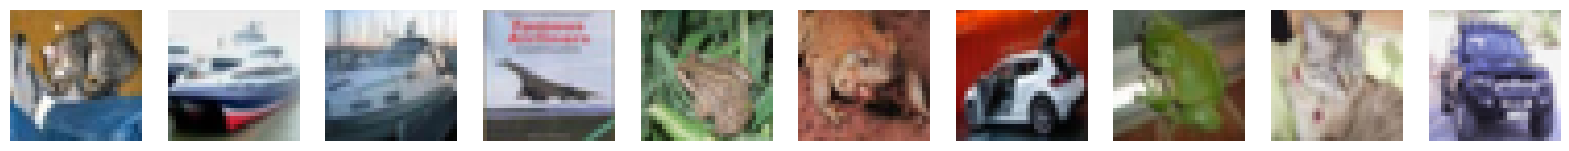

Reconstructions


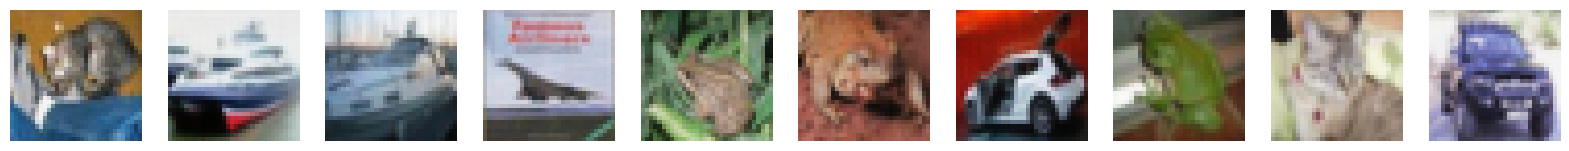

In [16]:
predictions = autoencoder.predict(example_images)

print("Example real images")
display(example_images)
print("Reconstructions")
display(predictions)

## 5. Embed using the encoder <a name="encode"></a>

In [10]:
# Load the saved models (in case kernel was restarted)
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

try:
    encoder = keras.models.load_model("./models/encoder.keras")
    autoencoder = keras.models.load_model("./models/autoencoder.keras")
    print("Models loaded successfully!")
except:
    print("Models not found. Please run the training section first.")

Models loaded successfully!


In [3]:
# Prepare example data if not already in memory
try:
    example_images
    print(f"Using existing example_images: {example_images.shape}")
except NameError:
    from tensorflow.keras import datasets
    (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
    x_test = x_test.astype("float32") / 255.0
    n_to_predict = 5000
    example_images = x_test[:n_to_predict]
    example_labels = y_test[:n_to_predict]
    print(f"Loaded and prepared example_images: {example_images.shape}")

Loaded and prepared example_images: (5000, 32, 32, 3)


In [4]:
# Encode the example images
# Note: encoder returns [embeddings, skip1, skip2, skip3], so we take only the first output
encoder_outputs = encoder.predict(example_images)
embeddings = encoder_outputs[0]  # Extract just the embeddings (128D)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [5]:
# Some examples of the embeddings
print(f"Embedding shape: {embeddings.shape}")
print(f"First 3 embeddings (showing first 10 dimensions only):")
print(embeddings[:3, :10])

Embedding shape: (5000, 128)
First 3 embeddings (showing first 10 dimensions only):
[[-2.170332    0.3851552   0.812517    0.41637802 -2.019848    7.3809967
   0.4604862  -0.24031101 -0.979729    0.46574607]
 [-3.1609356  -2.2049735  -2.4714894   1.0123008   1.6270943   8.747261
  -0.0624279  -0.17614903 -1.1056353  -0.9126816 ]
 [-3.713765    0.19560026 -1.8056033  -0.6880422  -0.3782031   9.424528
   0.25519192  0.83094305 -0.8943484  -0.3269966 ]]


### Dimensionality Reduction with UMAP

Since we have 128-dimensional embeddings, we can't directly visualize them in 2D. We'll use UMAP (Uniform Manifold Approximation and Projection) to reduce the dimensionality while preserving the structure of the data.

In [6]:
# Install umap-learn if not already installed
import subprocess
import sys

try:
    import umap
except ImportError:
    print("Installing umap-learn...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn"])
    import umap

print(f"UMAP version: {umap.__version__}")

/workspaces/cas-uzh/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UMAP version: 0.5.9.post2


In [7]:
# Reduce embeddings from 128D to 2D using UMAP
print("Reducing dimensionality from 128D to 2D using UMAP...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings_2d = reducer.fit_transform(embeddings)
print(f"Reduced embedding shape: {embeddings_2d.shape}")

Reducing dimensionality from 128D to 2D using UMAP...


/workspaces/cas-uzh/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Reduced embedding shape: (5000, 2)


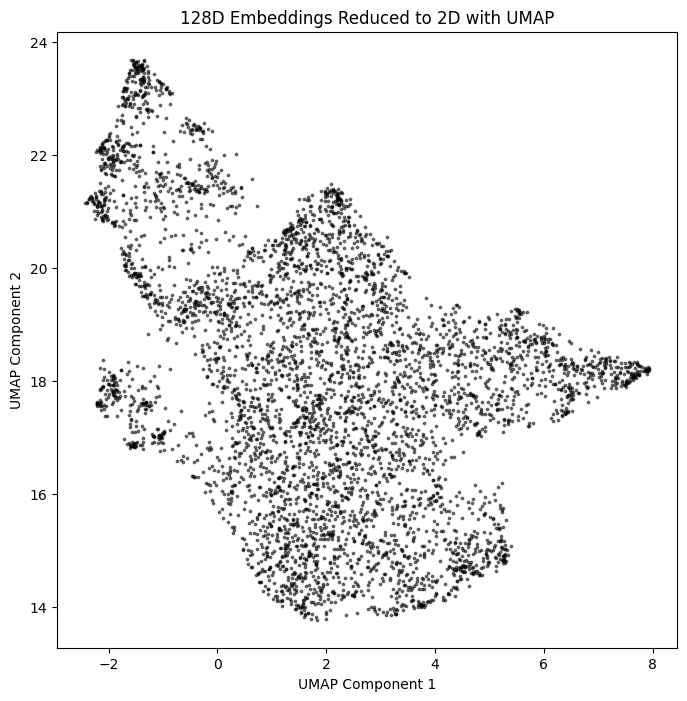

In [11]:
# Show the encoded points in 2D space (after UMAP reduction)
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c="black", alpha=0.5, s=3)
plt.title("128D Embeddings Reduced to 2D with UMAP")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

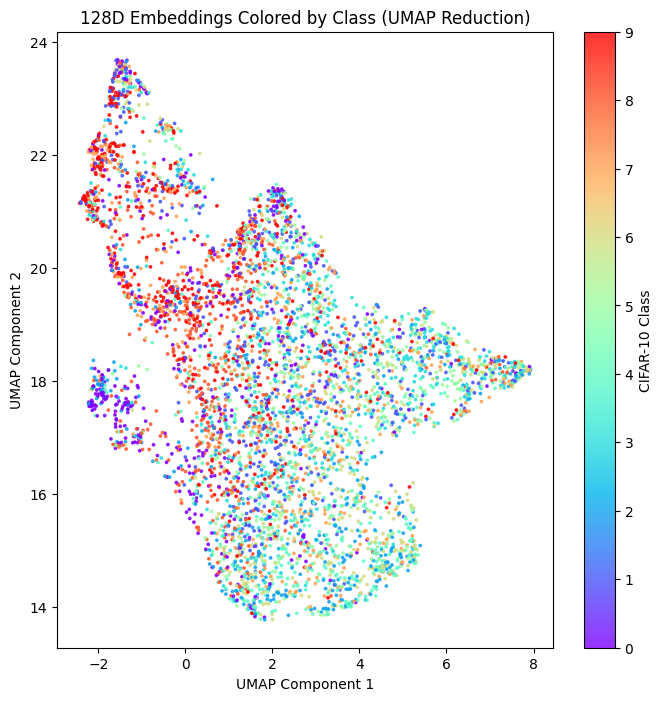

In [12]:
# Colour the embeddings by their label
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar(scatter, label="CIFAR-10 Class")
plt.title("128D Embeddings Colored by Class (UMAP Reduction)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

## 6. Results

### Model Architecture (U-Net using Skip Connections)
- Create direct pathways (instead of forcing all information through the 128D bottleneck)
 - Encoder Block 1 (16×16×32) → connects to → Decoder Block 3
 - Encoder Block 2 (8×8×64) → connects to → Decoder Block 2
 - Encoder Block 3 (4×4×128) → connects to → Decoder Block 1
- Encoder: 356K params (outputs embedding + 3 skip connections)
- Decoder: 699K params (receives skip connections via Concatenate layers)
- Total: 1.06M params (vs 862K in v4)

### Training
- Starting: Loss 0.0022 → Val Loss 0.0025
- Best epoch (19): Loss 0.000186 → Val Loss 0.0001049
- Final: Val Loss 0.0001092
- Learning Rate Scheduler: 
 - Epoch 8: 0.001 →0.0005 
 - Epoch 11: 0.0005 → 0.00025
 - Epoch 14: 0.00025 → 0.000125
 - Epoch 18: 0.000125 → 0.0000625

### Comparison with v4
- Much better training (validation loss dropped from 0.0044 to 0.0001049)
- Much sharper edges - fine details preserved
- Better texture reproduction - surfaces look more realistic
- Accurate colors - no washed out appearance
- Clearer object boundaries - objects are well-defined
- Class separation in the learned 128D embedding space